In [ ]:
# default_exp fastai-sequence

# Action Recognition using Fastai

> Ref. [3D Resnet for NIfTI images](https://gist.github.com/jcreinhold/78943cdeca1c5fca4a5af5d066bd8a8d)

In [ ]:
import cv2
from PIL import Image
from mpl_toolkits.axes_grid1 import axes_grid

import fastai
from fastai.vision import *
from fastai.vision.transform import *
import torchvision.transforms as transforms

from fastai.metrics import error_rate, accuracy

from actions_in_videos.dataset_ucf101 import UCF101
from actions_in_videos.avi import AVI
from actions_in_videos.models_resnet_3d import resnet50

Reload packages where content for package development

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
print(f'fastai version: {fastai.__version__}')
print(f'pytorch version: {torch.__version__}')
print('python version: {}.{}.{}'.format(sys.version_info.major, sys.version_info.minor, sys.version_info.micro))
#print(f'torchvision version: {torchvision.__version__}')

fastai version: 1.0.60
pytorch version: 1.4.0
python version: 3.7.4


Check GPU

In [ ]:
!nvidia-smi

Sat Mar  7 13:14:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Custom DataSets in Fastai
> ref. https://docs.fast.ai/basic_data.html#DataBunch  
https://docs.fast.ai/tutorial.itemlist.html  
https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4  

In [ ]:
SEQ_LEN = 2
kinetic_mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
kinetic_std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)

ucf_mean = np.array([0.485, 0.456, 0.406])
ucf_std = np.array([0.229, 0.224, 0.225])

In [ ]:
def sequence2np(seq:Tensor)->np.ndarray:
    "Convert from torch style `sequence` to numpy/matplotlib style."
    # reshape to have the seq as a single bigger image.
    seq = seq.reshape(1,3,seq.shape[0]*seq.shape[2],-1)     
    res = seq.cpu().permute(0,2,3,1).numpy().squeeze()  
    return res[...,0] if res.shape[2]==1 else res

In [ ]:
def seq2tensor(seq:NPArray, dtype:np.dtype)->TensorImage:
    """
    Convert sequence array to torch style image tensor.

    Can be used to convert the output of getVideoSequence into a tensor.
    For example:
    x = getVideoSequence(fn, num_of_frames=self._seq_len)
    f = seq2tensor(x, np.float32)
    f.shape
    torch.Size([16, 3, 240, 320])
    
    Returns:
    - torch tensor of size [seq_len, channel, height, width]
    
    """ 
    try:
        a = np.asarray(seq)
        if a.ndim==3 : a = np.expand_dims(a,3)
        a = np.transpose(a, (0, 3, 1, 2))
    except Exception as e:
        print(e)
#         # set_trace()
#         import pickle
#         f=open('./dump1','wb+'); pickle.dump(a,f); f.close()
        a = np.array([])
    return torch.from_numpy(a.astype(dtype, copy=False) )

In [ ]:
def getVideoSequence(filename, num_of_frames=16):
    """
    Extract a sequence of frames from an avi file.
    Returns: list of frames.
        for ex.  the output of a sequence of sixteen frames in color would be: seq_len, (channel, height, width)
                                                                                    16, (240, 320, 3)
    """
    ### load file from AVI
    cap = cv2.VideoCapture(str(filename))
    if not cap.isOpened(): 
        print(f"could not open {filename}") 
        return
    nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps     = cap.get(cv2.CAP_PROP_FPS)
    frame_index = np.random.randint(nFrames - num_of_frames)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)    
    try:
        video = []        
        f_count = 0
        while cap.isOpened() and f_count < num_of_frames:
            frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
            ret, frame = cap.read() 
            video.append(frame)
            f_count += 1
        cap.release() 
    except:
        print("\nException: " + filename)
        video = [] 
        cap.release() 
        set_trace()
    return video

In [ ]:
class Sequence(ItemBase): 
    """ Support applying transforms to sequence data (tensor of images) in `px`.        
        As all ItemBase classes, it is not usable until you have put it inside your custom ItemList though.        
        """
    def __init__(self, px:Tensor):
        self._obj = px # this is the original data.
        self._px  = px # this is the property that gets changed.
        self._seq_len = self._px.shape[0]        
        
    def clone(self):
        "Mimic the behavior of torch.clone for `Sequence` objects."
        return self.__class__(self.px.clone())
     
    @property
    def shape(self)->Tuple[int,int,int,int]: return self._px.shape
    @property
    def size(self)->Tuple[int,int,int]: return self.shape[-2:]
    @property
    def device(self)->torch.device: return self._px.device
    
    def __len__(self):
        return len(self._px[0])
    
    def __repr__(self): return f'{self.__class__.__name__} {tuple(self.shape)}'
    def _repr_png_(self):  return self._repr_image_format('png')
    
    def _repr_image_format(self, format_str):        
        rows = int(np.ceil(math.sqrt(self._seq_len)))
        axs = subplots(rows, rows)      
        for x, ax in zip(self._px, axs.flatten()): Image(x).show(ax=ax)
        for ax in axs.flatten()[len(self._px):]: ax.axis('off')
        plt.tight_layout()            
              
    def apply_tfms(self, tfms:TfmList, do_resolve:bool=True, xtra:Optional[Dict[Callable,dict]]=None,
                   size:Optional[Union[int,TensorImageSize]]=None, resize_method:ResizeMethod=None,
                   mult:int=None, padding_mode:str='reflection', mode:str='bilinear', remove_out:bool=True)->TensorImage:
        "Apply all `tfms` to each `Sequence Image`, if `do_resolve` picks value for random args."           
        print('apply_tfms')
        px_list = []
        for i,x in enumerate(self._px):
            x = Image(x)
            x = x.apply_tfms(tfms, do_resolve, xtra, size, resize_method, mult, padding_mode, mode, remove_out)
            px_list.append(x.data.numpy())        
        res = np.asarray(px_list, np.float32)
        self._px = torch.from_numpy(res.astype(np.float32, copy=False) )
        return self
    
    @property
    def data(self)->TensorImage:
        "Return this sequence pixels as a tensor."
        return self._px
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=None, y:Any=None, **kwargs):
        "Show image on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        cmap = ifnone(cmap, defaults.cmap)       
        image = self._px[0]               
        ax = show_image(image, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize)
        if y is not None: y.show(ax=ax, **kwargs)
        if title is not None: ax.set_title(title)               

In [ ]:
def channel_view_seq(x:Tensor)->Tensor:
    "Make channel the first axis of `x` of a sequence and flatten remaining axes"
    return x.transpose(0,2).contiguous().view(x.shape[2],-1)


class SequenceDataBunch(DataBunch):
    def batch_stats(self, funcs:Collection[Callable]=None, ds_type:DatasetType=DatasetType.Train)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
#        set_trace()
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=ds_type, denorm=False)[0].cpu()
        return [func(channel_view_seq(x), 1) for func in funcs]

    def normalize(self, stats:Collection[Tensor]=None, do_x:bool=True, do_y:bool=False)->None:
        "Add normalize transform using `stats` (defaults to `DataBunch.batch_stats`)"
        if getattr(self,'norm',False): raise Exception('Can not call normalize twice')
        if stats is None: self.stats = self.batch_stats()
        else:             self.stats = stats
        self.norm,self.denorm = normalize_funcs(*self.stats, do_x=do_x, do_y=do_y)
        self.add_tfm(self.norm)
        print(self.add_tfm)
        return self
    

In [ ]:
class SequenceList(ItemList): 
    """
       Subclass ImageList to use our own image opening function
       This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    
    # _processor
    _bunch = SequenceDataBunch
    _label_cls=None  # If set to one, fastai selects one class that should fit.
    
    _seq_len=SEQ_LEN
    def __init__(self, items, **kwargs):
        super().__init__(items, **kwargs)          
      
    def open(self, fn:PathOrStr, seq_len=16)->Image:
        #avi = AVI(fn, verbose=False, img_type=np.float32)
        #x = avi.getRandomSequence(seq_len=seq_len, sample_interval=1)
        got_video=False
        while(got_video==False):
            x = getVideoSequence(fn, num_of_frames=self._seq_len)
            ## This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor                               
            x = seq2tensor(x, np.float32)
            if len(x.shape) == 4:
                break
            print(f'Error while reading video: {fn}')        
        x.div_(255)  
        return Sequence(x)            
    
    def get(self, i):
        "Defines how to construct an ItemBase from the data in the ItemList.items array"
        fn = super().get(i)
        res = self.open(fn, seq_len=self._seq_len)
        return res
    
    def reconstruct(self, t:Tensor): 
        # this is to remove normalisation if was applied before:        
#         mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
#         std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)
#         seq = np.zeros(t.shape)
#         for i, img in enumerate(t):
#             for j, (f, m, s) in enumerate(zip(img, mean, std)):  # loop through the channels:  
#                 seq[i,j,:,:]=f*s+m # seq = std*t.numpy() + mean        
#         return Sequence(torch.from_numpy(seq.astype(np.float32, copy=False) ))
        ######################
        return Sequence(t.float().clamp(min=0,max=1))
        
#     def normalize(self, stats:Collection[Tensor]=None, do_x:bool=True, do_y:bool=False)->None:
#         "Add normalize transform using `stats` (defaults to `DataBunch.batch_stats`)"
#         if getattr(self,'norm',False): raise Exception('Can not call normalize twice')
#         if stats is None: self.stats = self.batch_stats()
#         else:             self.stats = stats
#         self.norm,self.denorm = normalize_funcs(*self.stats, do_x=do_x, do_y=do_y)
#         self.add_tfm(self.norm)
#         return self
    
    @classmethod
    def from_folder(cls, path, **kwargs):
        res = super().from_folder(path, **kwargs)
        res.path = path
        return res
    
    def split_by_files(self, names):
        return self.split_by_valid_func(lambda o: any(o.name in vn for vn in names))
    
    def split_by_fname_file(self, fname, path=None, **kwargs):        
        "Split the data by using the names in `fname` for the validation set. `path` will override `self.path`."        
        path = Path(ifnone(path, self.path))
        relative_valid_names = loadtxt_str(path/fname)
        valid_names = [str(Path(self.path).joinpath(Path(fn))) for fn in relative_valid_names]        
        return self.split_by_files(valid_names)                    
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):             
            x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()        

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [ ]:
# data = (SequenceList.from_folder('../data/UCF101/UCF-101/'))

In [ ]:
# data[101]

In [ ]:
def sequence_collate(batch):
    try:
        len_batch = len(batch) # original batch length
        batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
        batch = list(filter (lambda x: len(x[0])>0, batch))  # filter out all the empty ones.
        
        if len_batch > len(batch): 
            # if there are samples missing just use existing members, doesn't work if you reject every sample in a batch
            diff = len_batch - len(batch)
            print(f'sequence_collate - diff is {diff}')
            
        batch = torch.utils.data.dataloader.default_collate(to_data(batch))        
    except Exception as e:            
        print(e)
        set_trace()
    return batch

In [ ]:
def get_y_func(o):
    if str(o.parents[0]).split('/')[-1] == 'models':
        print(o)
        print(str(o.parents[0]).split('/')[-1]) 
    return str(o.parents[0]).split('/')[-1]

get_y = lambda o:str(o.parents[0]).split('/')[-1]

In [ ]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0, p_affine=0.5, p_lighting=0.5)

In [ ]:
# tfms

In [ ]:
data_path = '../data/UCF101/UCF-5/'

In [ ]:
data = (SequenceList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
        .split_by_fname_file(fname='ucf-5-testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/') 
        .label_from_func(get_y_func)         # How to label
        .transform(tfms, size=224)           # Data augmentation? -> use tfms with a size of 224
        .databunch(bs=64, collate_fn=sequence_collate))    

apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms


apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms


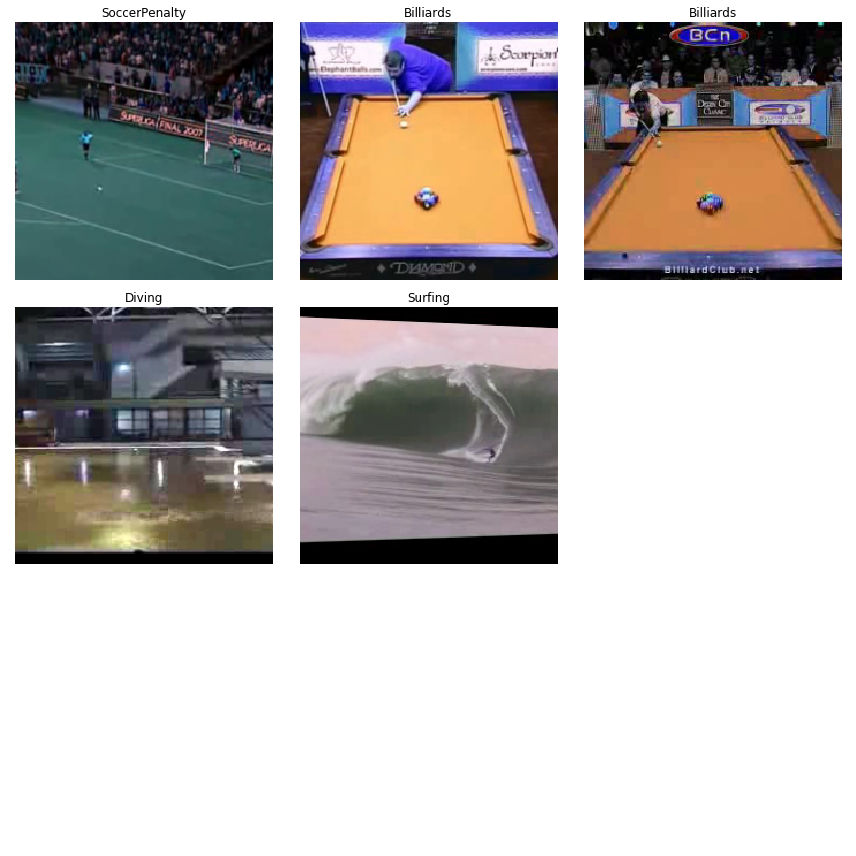

In [ ]:
data.show_batch()

apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms
apply_tfms


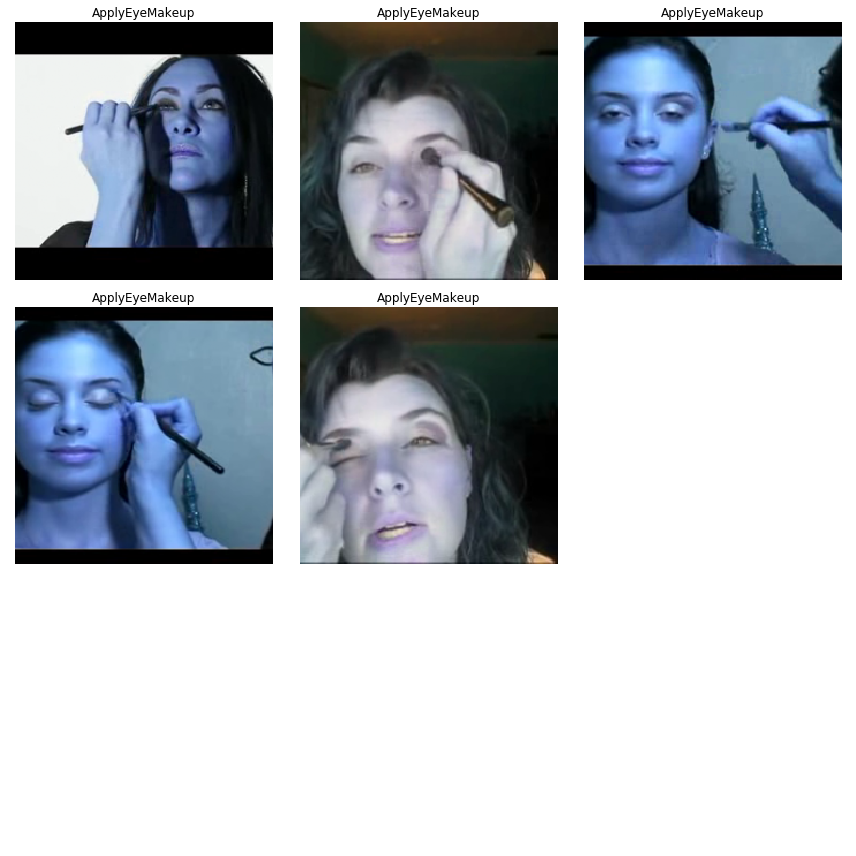

In [ ]:
data.show_batch(ds_type=DatasetType.Valid)

In [ ]:
if True:
    set_trace()
    data.show_batch(ds_type=DatasetType.Valid)

> <ipython-input-78-ee7d07c0b42d>(3)<module>()
-> data.show_batch(ds_type=DatasetType.Valid)
(Pdb) s
--Call--
> /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py(184)show_batch()
-> def show_batch(self, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse:bool=False, **kwargs)->None:
(Pdb) list
179  	        "Get `item` into a batch. Optionally `detach` and `denorm`."
180  	        ds = self.single_ds
181  	        with ds.set_item(item):
182  	            return self.one_batch(ds_type=DatasetType.Single, detach=detach, denorm=denorm, cpu=cpu)
183  	
184  ->	    def show_batch(self, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse:bool=False, **kwargs)->None:
185  	        "Show a batch of data in `ds_type` on a few `rows`."
186  	        x,y = self.one_batch(ds_type, True, True)
187  	        if reverse: x,y = x.flip(0),y.flip(0)
188  	        n_items = rows **2 if self.train_ds.x._square_show else rows
189  	        if self.dl(ds_type).batch_size < n_ite

BdbQuit: 

Unnormalised statistics:

In [ ]:
data.batch_stats()

[tensor([0.3476, 0.3764, 0.3793]), tensor([0.2658, 0.2646, 0.2666])]

In [ ]:
data = data.normalize((kinetic_mean, kinetic_std))

<bound method DataBunch.add_tfm of SequenceDataBunch;

Train: LabelList (9537 items)
x: SequenceList
Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224)
y: CategoryList
HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking
Path: ../data/UCF101/UCF-101;

Valid: LabelList (3783 items)
x: SequenceList
Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224),Sequence (16, 3, 224, 224)
y: CategoryList
HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking
Path: ../data/UCF101/UCF-101;

Test: None>


In [ ]:
data.batch_stats()

[tensor([-0.5423, -0.2024,  0.1487]), tensor([1.8092, 1.8397, 1.7989])]

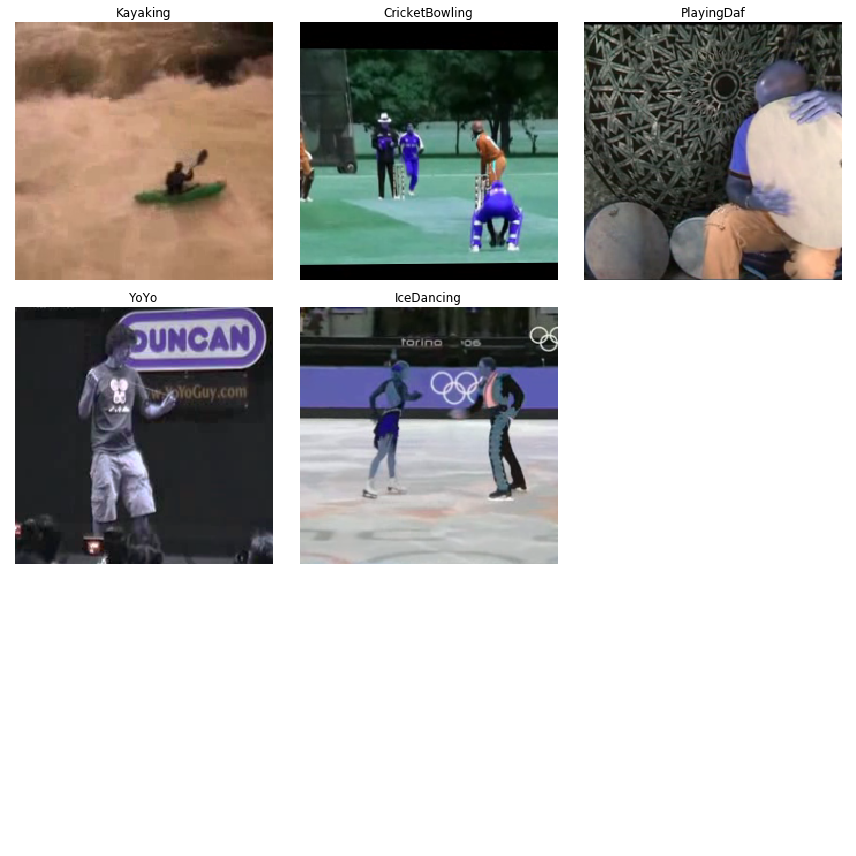

In [ ]:
data.show_batch()

In [ ]:
# data_path = '../data/UCF101/UCF-5'

In [ ]:
# data = (SequenceList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
#         .split_by_fname_file(fname='ucf-5-testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/')             #How to split in train/valid? -> use the folders
#         .label_from_func(get_y_func)         # How to label
#         .transform(tfms, size=224)           # Data augmentation? -> use tfms with a size of 224
#         .databunch(collate_fn=sequence_collate))    

In [ ]:
len(data.train_ds.y.classes)

101

In [ ]:
model =  resnet50(sample_size=224, sample_duration=SEQ_LEN)
pretrained = torch.load('./model-pretrained/resnet-50-kinetics.pth', map_location=torch.device('cpu'))

keys = [k for k,v in pretrained['state_dict'].items()]
pretrained_state_dict = {k[7:]: v.cpu() for k, v in pretrained['state_dict'].items()}
model.load_state_dict(pretrained_state_dict)
model.fc = nn.Linear(model.fc.weight.shape[1], len(data.train_ds.y.classes))

function resnet50


In [ ]:
# model

In [ ]:
for param in model.parameters():
    param.requires_grad_(False)

# for param in model.conv1.parameters():
#     param.requires_grad_(True)
# for param in model.bn1.parameters():
#     param.requires_grad_(True)
# for param in model.layer1.parameters():
#     param.requires_grad_(True)
# for param in model.layer2.parameters():
#     param.requires_grad_(True)
# for param in model.layer3.parameters():
#     param.requires_grad_(True)
for param in model.layer4[0].parameters():
    param.requires_grad_(True)
for param in model.fc.parameters():
    param.requires_grad_(True)

In [ ]:
#model

In [ ]:
loss = nn.CrossEntropyLoss()
learner = Learner(data, model, loss_func=loss, metrics=[accuracy], path='./', callback_fns=ShowGraph)

In [ ]:
learner.summary()

ResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv3d               [64, 16, 112, 112]   65,856     False     
______________________________________________________________________
BatchNorm3d          [64, 16, 112, 112]   128        False     
______________________________________________________________________
ReLU                 [64, 16, 112, 112]   0          False     
______________________________________________________________________
MaxPool3d            [64, 8, 56, 56]      0          False     
______________________________________________________________________
Conv3d               [64, 8, 56, 56]      4,096      False     
______________________________________________________________________
BatchNorm3d          [64, 8, 56, 56]      128        False     
______________________________________________________________________
Conv3d               [64, 8, 56, 56]      110,592    False     
_______________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


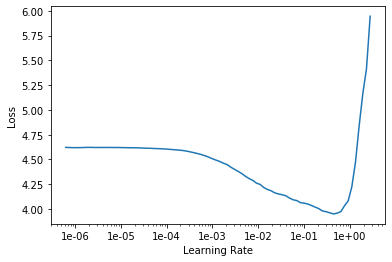

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.212892,2.515098,0.372191,06:05
1,1.015654,2.298143,0.425588,06:04
2,0.467975,2.656355,0.459688,06:04
3,0.186084,2.416920,0.489030,05:59
4,0.090868,2.274904,0.502247,06:00


axes don't match array
Error while reading video: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g22_c03.avi
axes don't match array
Error while reading video: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g05_c06.avi


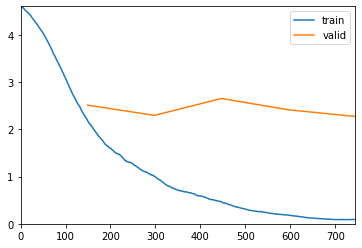

axes don't match array
Error while reading video: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi
axes don't match array
Error while reading video: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g05_c06.avi
axes don't match array
Error while reading video: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g05_c06.avi
axes don't match array
Error while reading video: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g05_c06.avi
axes don't match array
Error while reading video: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g05_c06.avi


In [ ]:
learner.fit_one_cycle(5,3e-3)

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)
interp.plot_top_losses(9, figsize=(20,20), heatmap=True)

In [ ]:
tfm = rand_zoom(scale=(1.,1.5))

rand_resize_crop(size:int, max_scale:float=2.0, ratios:Point=(0.75, 1.33))
brightness(x, change:uniform)
contrast(x, scale:log_uniform) 
crop(x, size, row_pct:uniform=0.5, col_pct:uniform=0.5)
crop_pad(x, size, padding_mode='reflection', row_pct:uniform=0.5, col_pct:uniform=0.5)
perspective_warp(c, magnitude:partial(uniform, size=8)=0, invert=False)


RESIZE: data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize()
    squish(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5) 

In [ ]:
learner.sched.plot_lr()

In [ ]:
from nbdev.export import *
notebook2script()